# distance and direciton

Let try to opt for distance and direction with

$L1loss(y_1-y_0, y_{true})$

where $y_1=model(x_1)$

So I'm optimising for the hidden states to be the correct distance and direcioton away. It's like the margin raning loss.


links:
- [loading](https://github.com/deep-diver/LLM-As-Chatbot/blob/main/models/alpaca.py)
- [dict](https://github.com/deep-diver/LLM-As-Chatbot/blob/c79e855a492a968b54bac223e66dc9db448d6eba/model_cards.json#L143)
- [prompt_format](https://github.com/deep-diver/PingPong/blob/main/src/pingpong/alpaca.py)

In [1]:
# import your package
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from typing import Optional, List, Dict, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset
from src.helpers.ds import shuffle_dataset_by
from pathlib import Path

import transformers

import lightning.pytorch as pl
# from dataclasses import dataclass

# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
# from sklearn.preprocessing import RobustScaler

from tqdm.auto import tqdm
import os

from loguru import logger
logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")



transformers.__version__


/media/wassname/SGIronWolf/projects5/elk/discovering_latent_knowledge/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'4.34.1'

In [3]:
from src.helpers.lightning import read_metrics_csv


# Datasets



In [4]:
[str(s) for s in sorted(Path('../.ds/').glob('*'))]


['../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_amazon_polarity_test_220',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_amazon_polarity_test_80',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_amazon_polarity_train_1690',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_amazon_polarity_train_190',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_amazon_polarity_train_50',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_glue_qnli_test_220',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_glue_qnli_train_1690',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_glue_qnli_train_190',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_imdb_test_219',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_imdb_test_220',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_imdb_train_1690',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_imdb_train_190',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_super_glue_boolq_test_220',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_super_glue_boolq_train_1690',


In [5]:
from datasets import load_from_disk, concatenate_datasets
from src.datasets.load import ds2df, load_ds, get_ds_name

# feats = ['hidden_states', 'head_activation_and_grad', 'mlp_activation_and_grad', 'residual_stream', 'w_grads_attn', 'w_grads_mlp', 'hidden_states2', 'residual_stream2', ]

fs = [
    # '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_amazon_polarity_test_220',
#  '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_amazon_polarity_test_80',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_amazon_polarity_train_1690',
#  '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_amazon_polarity_train_50',
#  '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_glue_qnli_test_220',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_glue_qnli_train_1690',
#  '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_imdb_test_219',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_imdb_train_1690',
#  '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_super_glue_boolq_test_220',
#  '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_super_glue_boolq_train_1690'
 ]

dss = [load_ds(f) for f in fs]


## QC datasets

In [6]:
from src.datasets.load import ds2df, load_ds, get_ds_name, filter_ds_to_known


In [7]:
for ds in dss:
    ds = ds.with_format('numpy')
    ds_name = get_ds_name(ds)
    print('ds', ds_name)
    df = ds2df(ds)
    
    # check llm accuracy
    d = df.query('instructed_to_lie==False')
    acc = (d.label_instructed==d.llm_ans).mean()
    assert np.isfinite(acc)
    print(f"\tacc    =\t{acc:2.2%} [N={len(d)}] - when the model is not lying... we get this task acc")
    
    # check LLM lie freq
    d = df.query('instructed_to_lie==True')
    acc = (d.label_instructed==d.llm_ans).mean()
    assert np.isfinite(acc)
    print(f"\tlie_acc=\t{acc:2.2%} [N={len(d)}] - when the model tries to lie... we get this acc")
    
    # check LLM lie freq
    ds_known = filter_ds_to_known(ds, verbose=False)
    df_known = ds2df(ds_known)
    d = df_known.query('instructed_to_lie==True')
    acc = (d.label_instructed==d.llm_ans).mean()
    assert np.isfinite(acc)
    print(f"\tknown_lie_acc=\t{acc:2.2%} [N={len(d)}] - when the model tries to lie and knows the answer... we get this acc")
    
    # check choice coverage
    mean_prob = ds['choice_probs'].sum(-1).mean()
    print(f"\tchoice_cov=\t{mean_prob:2.2%} - Our choices accounted for a mean probability of this")
    
    # view prompt example
    r = ds[0]
    print('prompt example:')
    print(r['input_truncated'], end="")
    print(r['text_ans'])
    
    print('='*80)
    print()
        

ds amazon_polarity
	acc    =	92.30% [N=844] - when the model is not lying... we get this task acc
	lie_acc=	13.36% [N=846] - when the model tries to lie... we get this acc
	known_lie_acc=	11.42% [N=692] - when the model tries to lie and knows the answer... we get this acc
	choice_cov=	45.17% - Our choices accounted for a mean probability of this
prompt example:
<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><

# Combine

In [8]:
dss_known = [filter_ds_to_known(d) for d in dss]
# './.ds/HuggingFaceH4starchat_beta-None-N_8000-ns_3-mc_0.2-2ffc1e'
ds = concatenate_datasets(dss_known)
ds = ds.with_format('numpy')
ds


select rows are 92.30% based on knowledge
select rows are 54.56% based on knowledge
select rows are 80.88% based on knowledge


Dataset({
    features: ['end_hidden_states', 'end_logits', 'choice_probs', 'label_true', 'instructed_to_lie', 'question', 'answer_choices', 'choice_ids', 'template_name', 'sys_instr_name', 'example_i', 'input_truncated', 'truncated', 'text_ans', 'ans'],
    num_rows: 3559
})

## Filter

In [9]:
# torch.tensor(ds['end_logits'][0])


In [10]:
# lets select only the ones where
df = ds2df(ds)
df


,label_true,instructed_to_lie,question,answer_choices,template_name,sys_instr_name,example_i,input_truncated,truncated,text_ans,ans,conf,llm_prob,llm_ans,label_instructed
0,False,True,You are about to immerse yourself into a thesp...,"[[No], [Yes]]",User_recommend_this_product,sphinx,140,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['No', 'good']",0.506096,0.506096,0.506096,True,True
1,False,False,"Below is an instruction that describes a task,...","[[Negative], [Positive]]",negative_or_positive_tone,truth,140,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['Ne', 'good']",0.489871,0.489871,0.489871,False,False
2,True,False,"Below is an instruction that describes a task,...","[[No], [Yes]]",User_recommend_this_product,truth,2607,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['Yes', 'good']",0.876584,0.876584,0.876584,True,True
3,False,True,In this exam you will be scored on your abilit...,"[[Negative], [Positive]]",convey_negative_or_positive_sentiment,this_is_an_exam,1492,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['Neg', 'good']",0.487854,0.487854,0.487854,False,True
4,False,False,"Below is an instruction that describes a task,...","[[Yes], [No]]",Is_this_review_negative,truth,1492,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['Yes', 'good']",0.125578,0.125578,0.125578,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3554,True,False,"Below is an instruction that describes a task,...","[[negative], [positive]]",Text Expressed Sentiment,truth,1395,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['pos', 'good']",0.997369,0.997369,0.997369,True,True
3555,True,False,"Below is an instruction that describes a task,...","[[negative], [positive]]",Movie Expressed Sentiment 2,truth,1239,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['negative', 'good']",0.638799,0.638799,0.638799,True,True
3556,False,True,You are about to immerse yourself into a thesp...,"[[negative], [positive]]",Text Expressed Sentiment,sphinx,1240,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['negative', 'good']",0.498250,0.498250,0.498250,False,True
3557,False,False,"Below is an instruction that describes a task,...","[[negative], [positive]]",Movie Expressed Sentiment 2,truth,964,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['negative', 'good']",0.497992,0.497992,0.497992,False,False


In [11]:
# QC: make sure we didn't lose all of the successful lies, which would make the problem trivial
df2= ds2df(ds)
df_subset_successull_lies = df2.query("instructed_to_lie==True & ((llm_ans==1)==label_instructed)")
print(f"after filtering we have {len(df_subset_successull_lies)} num successful lies out of {len(df2)} dataset rows")
assert len(df_subset_successull_lies)>0, "there should be successful lies in the dataset"


after filtering we have 224 num successful lies out of 3559 dataset rows


In [12]:
dss[-1][20]['end_hidden_states'].shape


(33, 4096, 2)

## Transform: Normalize by activation

In [13]:
# N = 1000
# small_ds = ds.select(range(N))
# b = N
# hs0 = small_ds['hs0'].reshape((b, -1))

# scaler = RobustScaler()
# hs1 = scaler.fit_transform(hs0)

# def normalize_hs(hs0, hs1):
#     shape=hs0.shape
#     b = len(hs0)
#     hs0 = scaler.transform(hs0.reshape((b, -1))).reshape(shape)
#     hs1 = scaler.transform(hs1.reshape((b, -1))).reshape(shape)
#     return {'hs0':hs0, 'hs1': hs1}

# # Plot
# plt.hist(hs0.flatten(), bins=155, range=[-5, 5], label='before', histtype='step')
# plt.hist(hs1.flatten(), bins=155, range=[-5, 5], label='after', histtype='step')
# plt.legend()
# plt.show()

# # # Test
# # small_dataset = ds.select(range(4))
# # small_dataset.map(normalize_hs, batched=True, batch_size=2, input_columns=['hs0', 'hs1'])

# # run
# ds = ds.map(normalize_hs, batched=True, input_columns=['hs0', 'hs1'])
# ds


In [14]:
df = ds2df(ds)
df.head(4)


,label_true,instructed_to_lie,question,answer_choices,template_name,sys_instr_name,example_i,input_truncated,truncated,text_ans,ans,conf,llm_prob,llm_ans,label_instructed
0,False,True,You are about to immerse yourself into a thesp...,"[[No], [Yes]]",User_recommend_this_product,sphinx,140,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['No', 'good']",0.506096,0.506096,0.506096,True,True
1,False,False,"Below is an instruction that describes a task,...","[[Negative], [Positive]]",negative_or_positive_tone,truth,140,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['Ne', 'good']",0.489871,0.489871,0.489871,False,False
2,True,False,"Below is an instruction that describes a task,...","[[No], [Yes]]",User_recommend_this_product,truth,2607,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['Yes', 'good']",0.876584,0.876584,0.876584,True,True
3,False,True,In this exam you will be scored on your abilit...,"[[Negative], [Positive]]",convey_negative_or_positive_sentiment,this_is_an_exam,1492,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['Neg', 'good']",0.487854,0.487854,0.487854,False,True


# Probe

In [15]:
from src.datasets.dm import imdbHSDataModule
from einops import reduce, einsum, rearrange


In [16]:


from src.probes.pl_ranking import PLConvProbeLinear
from torchmetrics.functional import accuracy, auroc, f1_score, jaccard_index, dice


# Params

In [17]:
# params
batch_size = 164
lr = 1e-3
wd = 1
max_rows = 40000

max_epochs = 100
device = 'cuda'

# quiet please
torch.set_float32_matmul_precision('medium')
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*sampler has shuffling enabled, it is strongly recommended that.*")
warnings.filterwarnings("ignore", ".*has been removed as a dependency of.*")


## Metrics

In [18]:
def get_acc_subset(df, query, verbose=True):
    if query: df = df.query(query)
    acc = (df['probe_pred']==df['y']).mean()
    if verbose:
        print(f"acc={acc:2.2%},\tn={len(df)},\t[{query}] ")
    return acc

def calc_metrics(dm, trainer, net, use_val=False, verbose=True):
    dl_test = dm.test_dataloader()
    rt = trainer.predict(net, dataloaders=dl_test)
    y_test_pred = np.concatenate(rt)
    splits = dm.splits['test']
    df_test = dm.df.iloc[splits[0]:splits[1]].copy()
    df_test['probe_pred'] = y_test_pred>0.
    
    if use_val:
        dl_val = dm.val_dataloader()
        rv = trainer.predict(net, dataloaders=dl_val)
        y_val_pred = np.concatenate(rv)
        splits = dm.splits['val']
        df_val = dm.df.iloc[splits[0]:splits[1]].copy()
        df_val['probe_pred'] = y_val_pred>0.
        
        df_test = pd.concat([df_val, df_test])

    if verbose:
        print('probe results on subsets of the data')
    acc = get_acc_subset(df_test, '', verbose=verbose)
    get_acc_subset(df_test, 'instructed_to_lie==True', verbose=verbose) # it was ph told to lie
    get_acc_subset(df_test, 'instructed_to_lie==False', verbose=verbose) # it was told not to lie
    get_acc_subset(df_test, 'llm_ans==label_true', verbose=verbose) # the llm gave the true ans
    get_acc_subset(df_test, 'llm_ans==label_instructed', verbose=verbose) # the llm gave the desired ans
    acc_lie_lie = get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans==label_instructed', verbose=verbose) # it was told to lie, and it did lie
    acc_lie_truth = get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans!=label_instructed', verbose=verbose)
    
    a = get_acc_subset(df_test, 'instructed_to_lie==False & llm_ans==label_instructed', verbose=False)
    b = get_acc_subset(df_test, 'instructed_to_lie==False & llm_ans!=label_instructed', verbose=False)
    c = get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans==label_instructed', verbose=False)
    d = get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans!=label_instructed', verbose=False)
    d1 = pd.DataFrame([[a, b], [c, d]], index=['instructed_to_lie==False', 'instructed_to_lie==True'], columns=['llm_ans==label_instructed', 'llm_ans!=label_instructed'])
    d1 = pd.DataFrame([[a, b], [c, d]], index=['tell a truth', 'tell a lie'], columns=['did', 'didn\'t'])
    d1.index.name = 'instructed to'
    d1.columns.name = 'llm gave'
    print('probe accuracy for quadrants')
    display(d1.round(2))
    
    if verbose:
        print(f"⭐PRIMARY METRIC⭐ acc={acc:2.2%} from probe")
        print(f"⭐SECONDARY METRIC⭐ acc_lie_lie={acc_lie_lie:2.2%} from probe")
    return dict(acc=acc, acc_lie_lie=acc_lie_lie, acc_lie_truth=acc_lie_truth)


In [19]:
import re
def transform_dl_k(k: str) -> str:
    p = re.match(r'test\/(.+)\/dataloader_idx_\d', k)
    return p.group(1) if p else k

def rename(rs):
    ks = ['train', 'val', 'test']
    rs = {ks[i]: {transform_dl_k(k):v for k,v in rs[i].items()} for i in range(3)}
    return rs


## DM

In [20]:
# # TEMP try with the counterfactual residual stream...

# dm = imdbHSDataModule2(ds, batch_size=batch_size, x_cols=['residual_stream', 'residual_stream2'])
# dm.setup('train')

# dl_train = dm.train_dataloader()
# dl_val = dm.val_dataloader()
# print(len(dl_train), len(dl_val))
# x, y = next(iter(dl_train))
# x.shape


In [21]:
n = min(max_rows, len(ds))
ds2 = ds.select(range(n))
ds2


Dataset({
    features: ['end_hidden_states', 'end_logits', 'choice_probs', 'label_true', 'instructed_to_lie', 'question', 'answer_choices', 'choice_ids', 'template_name', 'sys_instr_name', 'example_i', 'input_truncated', 'truncated', 'text_ans', 'ans'],
    num_rows: 3559
})

In [22]:
# df['example_i']


# Train

In [23]:

# TEMP try with the counterfactual residual stream...
dm = imdbHSDataModule(ds2, batch_size=batch_size)
dm.setup('train')


In [24]:
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
print(len(dl_train), len(dl_val))
x, x1, y = next(iter(dl_train))
print(x.shape, 'x')
if x.ndim==3: x = x.unsqueeze(-1)

c_in = x.shape[1:-1]
net = PLConvProbeLinear(c_in=c_in, total_steps=max_epochs*len(dl_train),  lr=lr, 
        weight_decay=wd, 
        depth=5,
        hs=128
        # x_feats=x_feats
        )
print(c_in)
with torch.no_grad():
    net(x)


11 6
torch.Size([164, 32, 4096]) x
torch.Size([32, 4096])


/media/wassname/SGIronWolf/projects5/elk/discovering_latent_knowledge/.venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv1d(input, weight, bias, self.stride,


In [25]:
from torchinfo import summary
summary(net, input_data=x) # input_size=(batch_size, 1, 28, 28))


Layer (type:depth-idx)                        Output Shape              Param #
PLConvProbeLinear                             [164]                     --
├─Sequential: 1-1                             [164, 1, 32]              --
│    └─BatchNorm1d: 2-1                       [164, 4096, 32]           --
│    └─InceptionBlock: 2-2                    [164, 512, 32]            --
│    │    └─ConvBlock: 3-1                    [164, 128, 32]            524,672
│    │    └─ModuleList: 3-2                   --                        364,032
│    │    └─Sequential: 3-3                   [164, 128, 32]            524,672
│    │    └─BatchNorm1d: 3-4                  [164, 512, 32]            1,024
│    │    └─Dropout: 3-5                      [164, 512, 32]            --
│    │    └─ReLU: 3-6                         [164, 512, 32]            --
│    └─InceptionBlock: 2-3                    [164, 512, 32]            --
│    │    └─ConvBlock: 3-7                    [164, 128, 32]            65,92

In [26]:
trainer = pl.Trainer(precision="16-mixed",
                gradient_clip_val=20,
                max_epochs=max_epochs, log_every_n_steps=3, 
                
                # enable_progress_bar=False, enable_model_summary=False
                )
trainer.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type       | Params
------------------------------------
0 | conv | Sequential | 3.4 M 
1 | head | Sequential | 37    
------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.610    Total estimated model params size (MB)


/media/wassname/SGIronWolf/projects5/elk/discovering_latent_knowledge/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:211: You called `self.log('val/n', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.


Epoch 0:  18%|█▊        | 2/11 [00:00<00:01,  6.86it/s, v_num=12]

/media/wassname/SGIronWolf/projects5/elk/discovering_latent_knowledge/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:211: You called `self.log('train/n', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.


Epoch 99: 100%|██████████| 11/11 [00:01<00:00,  5.71it/s, v_num=12]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 11/11 [00:02<00:00,  5.32it/s, v_num=12]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0:   9%|▉         | 1/11 [00:00<00:00, 48.29it/s]

/media/wassname/SGIronWolf/projects5/elk/discovering_latent_knowledge/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:211: You called `self.log('test/n', ...)` in your `test_step.0` but the value needs to be floating point. Converting it to torch.float32.


Testing DataLoader 1:  50%|█████     | 3/6 [00:00<00:00, 17.40it/s]  

/media/wassname/SGIronWolf/projects5/elk/discovering_latent_knowledge/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:211: You called `self.log('test/n', ...)` in your `test_step.1` but the value needs to be floating point. Converting it to torch.float32.


Testing DataLoader 2:  50%|█████     | 3/6 [00:00<00:00, 17.83it/s]

/media/wassname/SGIronWolf/projects5/elk/discovering_latent_knowledge/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:211: You called `self.log('test/n', ...)` in your `test_step.2` but the value needs to be floating point. Converting it to torch.float32.


Testing DataLoader 2: 100%|██████████| 6/6 [00:00<00:00, 15.34it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.8802698254585266     │    0.6764044761657715     │    0.7067415714263916     │
│         test/loss         │    0.0101438866143732     │    0.06013626455706023    │    0.09860628545979422    │
│          test/n           │          1779.0           │           890.0           │           890.0           │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 16.06it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 16.58it/s]
probe results on subsets of the data
acc=69.16%,	n=1780,	[] 
acc=61.01%,	n=754,	[instructed_to_lie==True] 
acc=75.15%,	n=1026,	[instructed_to_lie==False] 
acc=68.67%,	n=1650,	[llm_ans==label_true] 
acc=75.17%,	n=1156,	[llm_ans==label_instructed] 
acc=75.38%,	n=130,	[instructed_to_lie==True & llm_ans==label_instructed] 
acc=58.01%,	n=624,	[instructed_to_lie==True & llm_ans!=label_instructed] 
probe accuracy for quadrants


llm gave,did,didn't
instructed to,,
tell a truth,0.75,NaN
tell a lie,0.75,0.58


⭐PRIMARY METRIC⭐ acc=69.16% from probe
⭐SECONDARY METRIC⭐ acc_lie_lie=75.38% from probe


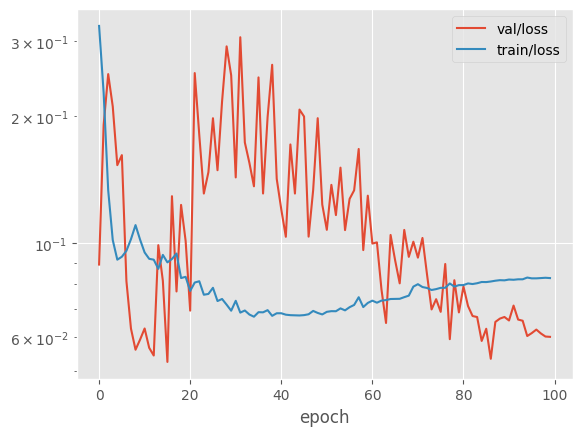

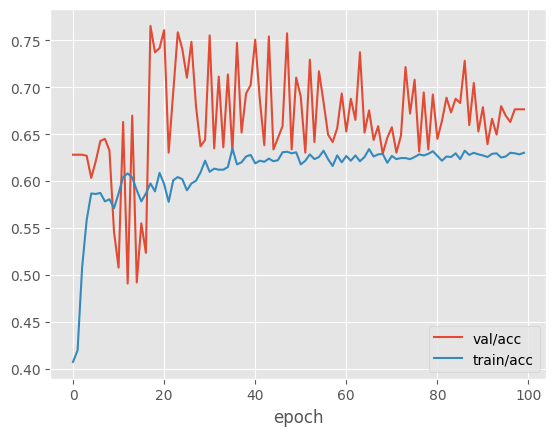

In [27]:

# look at hist
df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path).ffill().bfill()
for key in ['loss']:
    df_hist[[c for c in df_hist.columns if key in c]].plot(logy=True)
    
for key in ['acc']:
    df_hist[[c for c in df_hist.columns if key in c]].plot()
df_hist

# predict
dl_test = dm.test_dataloader()
# print(f"training with x_feats={x_feats} with c={c}")
rs = trainer.test(net, dataloaders=[dl_train, dl_val, dl_test])

testval_metrics = calc_metrics(dm, trainer, net, use_val=True)
rs = rename(rs)
# rs['test'] = {**rs['test'], **test_metrics}
rs['test']['acc_lie_lie'] = testval_metrics['acc_lie_lie']
rs['testval_metrics'] = rs['test']


In [28]:
df_hist['train/acc']


epoch
0     0.407532
1     0.419899
2     0.508151
3     0.558741
4     0.586847
        ...   
95    0.626194
96    0.630129
97    0.629567
98    0.628443
99    0.630129
Name: train/acc, Length: 100, dtype: float64

# how well does it generalize?

In [29]:
# lets see how it generalises to a new ds
fs_test = [
     '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_super_glue_boolq_test_220',
      '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_super_glue_boolq_train_1690'
]
dss_test = [load_ds(f) for f in fs_test]

dss_test_known = [filter_ds_to_known(d) for d in dss_test]
# './.ds/HuggingFaceH4starchat_beta-None-N_8000-ns_3-mc_0.2-2ffc1e'
ds_test = concatenate_datasets(dss_test_known)
ds_test = ds_test.with_format('numpy')
ds_test


# TEMP try with the counterfactual residual stream...
dm_test = imdbHSDataModule(ds_test, batch_size=batch_size)
dm_test.setup('train')

dl_train2 = dm_test.train_dataloader()
dl_val2 = dm_test.val_dataloader()
dl_test2 = dm_test.test_dataloader()


select rows are 76.36% based on knowledge
select rows are 81.29% based on knowledge


In [30]:
# print(f"training with x_feats={x_feats} with c={c}")
rs2 = trainer.test(net, dataloaders=[dl_train2, dl_val2, dl_test2])

testval_metrics2 = calc_metrics(dm_test, trainer, net, use_val=True)
rs2 = rename(rs2)
# rs['test'] = {**rs['test'], **test_metrics}
rs2['test']['acc_lie_lie'] = testval_metrics2['acc_lie_lie']
rs2['testval_metrics'] = rs['test']


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 2: 100%|██████████| 2/2 [00:00<00:00, 24.29it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.8330605626106262     │     0.843137264251709     │    0.8366013169288635     │
│         test/loss         │    0.03758676684171327    │    0.04079683127574847    │   0.043710207573020236    │
│          test/n           │           611.0           │           306.0           │           306.0           │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 23.78it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 18.63it/s]
probe results on subsets of the data
acc=83.99%,	n=612,	[] 
acc=75.65%,	n=230,	[instructed_to_lie==True] 
acc=89.01%,	n=382,	[instructed_to_lie==False] 
acc=85.25%,	n=590,	[llm_ans==label_true] 
acc=86.88%,	n=404,	[llm_ans==label_instructed] 
acc=50.00%,	n=22,	[instructed_to_lie==True & llm_ans==label_instructed] 
acc=78.37%,	n=208,	[instructed_to_lie==True & llm_ans!=label_instructed] 
probe accuracy for quadrants


llm gave,did,didn't
instructed to,,
tell a truth,0.89,NaN
tell a lie,0.50,0.78


⭐PRIMARY METRIC⭐ acc=83.99% from probe
⭐SECONDARY METRIC⭐ acc_lie_lie=50.00% from probe
